## CNN

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from keras import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten,
                          MaxPooling2D)
from keras.optimizers import Adam, Adamax
from keras_preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from utils import (load_history_from_file, load_model_from_file,
                   plot_confusion_matrix, plot_training_history, save_history,
                   save_model)

In [2]:
sns.set_style("whitegrid")

## Data

Weather images are taken from this [source](https://data.mendeley.com/datasets/4drtyfjtfy/1).

In [3]:
dataset_dir = "dataset"

In [4]:
images_df = pd.DataFrame(columns=["filename", "label"])

images_df["filename"] = [os.path.join(os.getcwd(),dataset_dir , i) for i in os.listdir(dataset_dir)]
images_df["label"] = (images_df["filename"].str.split("\\")
               .str[-1].str.split(".")
               .str[0].str.replace("[^a-zA-Z]", "", regex=True)
)
images_df.head()

,filename,label
0,c:\Users\Manik\projects\deep-learning-portfoli...,cloudy
1,c:\Users\Manik\projects\deep-learning-portfoli...,cloudy
2,c:\Users\Manik\projects\deep-learning-portfoli...,cloudy
3,c:\Users\Manik\projects\deep-learning-portfoli...,cloudy
4,c:\Users\Manik\projects\deep-learning-portfoli...,cloudy


In [5]:
images_df["label"].value_counts()

sunrise    357
cloudy     300
shine      253
rain       215
Name: label, dtype: int64

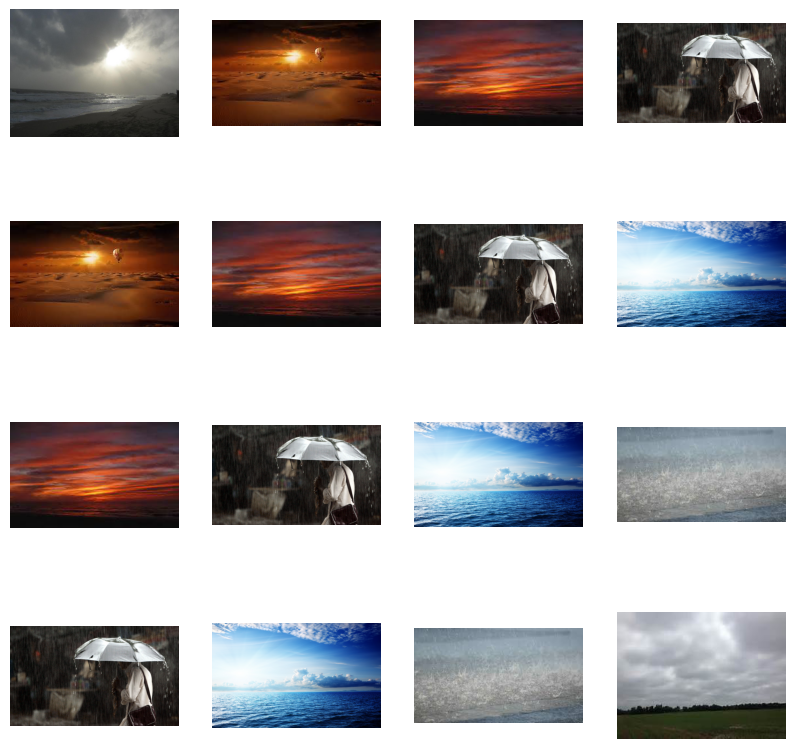

In [6]:
random_images = np.random.choice(images_df['filename'], size=16, replace=False)

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        img = Image.open(random_images[i + j])
        ax[i, j].imshow(img)
        ax[i, j].axis('off')
plt.show()

In [7]:
for i in range(4):
    for j in range(4):
        img = Image.open(random_images[i + j])
        print(img.size)

(874, 664)
(315, 197)
(257, 161)
(700, 415)
(315, 197)
(257, 161)
(700, 415)
(1920, 1200)
(257, 161)
(700, 415)
(1920, 1200)
(299, 168)
(700, 415)
(1920, 1200)
(299, 168)
(230, 173)


They have different shapes, so rescailing will be required.

In [8]:
train_df, test_valid_df = train_test_split(images_df, train_size=0.8, shuffle= True,
                                           random_state=30_08_2000, stratify=images_df.label)
valid_df, test_df = train_test_split(test_valid_df,  train_size= 0.6, shuffle= True, 
                                     random_state=30_08_2000, stratify=test_valid_df.label)

In [9]:
print(f"Train size: {len(train_df)}")
print(f"Valid size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

Train size: 900
Valid size: 135
Test size: 90


In [10]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

In [11]:
ts_length = len(test_df)
test_batch_size = 10
test_steps = ts_length // test_batch_size

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filename', y_col='label', target_size=img_size,
                                       class_mode= 'categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filename', y_col='label', target_size=img_size, 
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filename', y_col='label', target_size=img_size, 
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 900 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.


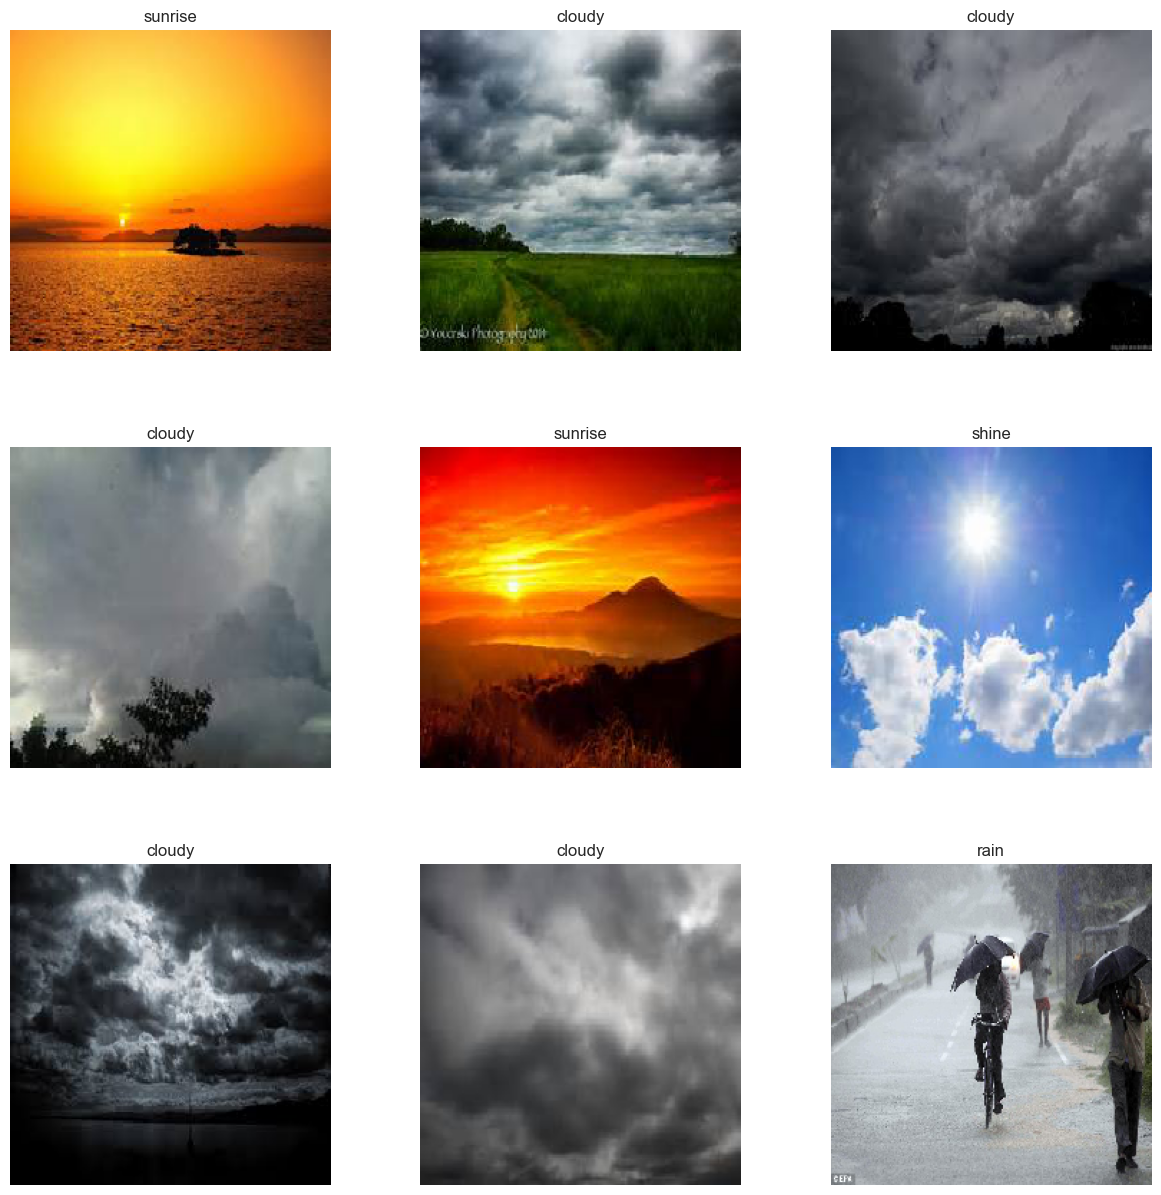

In [12]:
first_test_batch = test_gen.next()
classes_names = list(test_gen.class_indices.keys())

images, labels = first_test_batch[0], first_test_batch[1]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()
for i in range(9):
    axes[i].imshow(images[i])
    axes[i].set_title(classes_names[np.argmax(labels[i])])
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.3)
plt.show()

### CNN network

First, let's use Optuna to find the best hyperparameters for the CNN network.

In [25]:
def objective(trial):
    model = Sequential()

    filters_num = trial.suggest_int("filters_num", 8, 32)
    kernel_size = trial.suggest_int("kernel_size", 2, 10)
    pool_size = trial.suggest_int("pool_size", 2, 4)
    convolutional_layers_num = trial.suggest_int("convolutional_layers_num", 1, 2)
    use_batch_norm = trial.suggest_categorical("use_batch_norm", [True, False])

    model.add(Conv2D(filters=filters_num, kernel_size=kernel_size, activation='relu', input_shape=img_shape))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))

    for _ in range(convolutional_layers_num):
        model.add(Conv2D(filters=filters_num, kernel_size=3, activation='relu'))
        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    history = model.fit(train_gen, validation_data=valid_gen, epochs=10, verbose=0)
    return history.history["val_accuracy"][-1]

In [26]:
study = optuna.create_study(direction="maximize", study_name="CNN Hyperparameter Optimization")
study.optimize(objective, n_trials=10)

[I 2024-01-10 13:46:38,897] A new study created in memory with name: CNN Hyperparameter Optimization
[I 2024-01-10 13:50:22,835] Trial 0 finished with value: 0.5703703761100769 and parameters: {'filters_num': 30, 'kernel_size': 5, 'pool_size': 2, 'convolutional_layers_num': 2, 'use_batch_norm': True, 'learning_rate': 0.00148679741597246}. Best is trial 0 with value: 0.5703703761100769.
[I 2024-01-10 13:52:22,863] Trial 1 finished with value: 0.7481481432914734 and parameters: {'filters_num': 23, 'kernel_size': 10, 'pool_size': 3, 'convolutional_layers_num': 2, 'use_batch_norm': False, 'learning_rate': 0.004767254253207538}. Best is trial 1 with value: 0.7481481432914734.
[I 2024-01-10 13:55:13,563] Trial 2 finished with value: 0.4000000059604645 and parameters: {'filters_num': 21, 'kernel_size': 6, 'pool_size': 3, 'convolutional_layers_num': 1, 'use_batch_norm': True, 'learning_rate': 0.00017717748094955518}. Best is trial 1 with value: 0.7481481432914734.
[I 2024-01-10 13:57:53,161] T

In [27]:
study.best_params

{'filters_num': 32,
 'kernel_size': 6,
 'pool_size': 2,
 'convolutional_layers_num': 2,
 'use_batch_norm': False,
 'learning_rate': 0.0004126708188867759}

In [20]:
filters_num = 8
pool_size = (2, 2)
learning_rate = 0.0005
kernel_size = 6
filters_num = 32

In [31]:
model = Sequential()

model.add(Conv2D(filters=filters_num, kernel_size=kernel_size, activation='relu', input_shape=img_shape))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Conv2D(filters=filters_num, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Conv2D(filters=filters_num, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

model._name = "CNN"
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 219, 219, 32)      3488      
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 109, 109, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 107, 107, 32)      9248      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 53, 53, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 51, 51, 32)        9248      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 25, 25, 32)       0       

In [33]:
cnn_history = model.fit(train_gen, validation_data=valid_gen, epochs=10, verbose=1)

Epoch 1/10
15/15 [==============================] - 11s 738ms/step - loss: 0.8303 - accuracy: 0.6178 - val_loss: 0.6498 - val_accuracy: 0.7630
Epoch 2/10
15/15 [==============================] - 11s 733ms/step - loss: 0.6600 - accuracy: 0.7322 - val_loss: 0.5390 - val_accuracy: 0.8000
Epoch 3/10
15/15 [==============================] - 12s 815ms/step - loss: 0.6105 - accuracy: 0.7733 - val_loss: 0.5191 - val_accuracy: 0.8148
Epoch 4/10
15/15 [==============================] - 12s 824ms/step - loss: 0.5312 - accuracy: 0.8033 - val_loss: 0.4060 - val_accuracy: 0.8444
Epoch 5/10
15/15 [==============================] - 11s 776ms/step - loss: 0.4982 - accuracy: 0.8156 - val_loss: 0.3664 - val_accuracy: 0.8370
Epoch 6/10
15/15 [==============================] - 11s 679ms/step - loss: 0.4124 - accuracy: 0.8433 - val_loss: 0.3023 - val_accuracy: 0.8815
Epoch 7/10
15/15 [==============================] - 12s 756ms/step - loss: 0.3525 - accuracy: 0.8789 - val_loss: 0.3056 - val_accuracy: 0.8963

In [ ]:
# save_model(model, "cnn")
# save_history(cnn_history, "cnn")

In [13]:
model_cnn = load_model_from_file("cnn")
cnn_history = load_history_from_file("cnn")

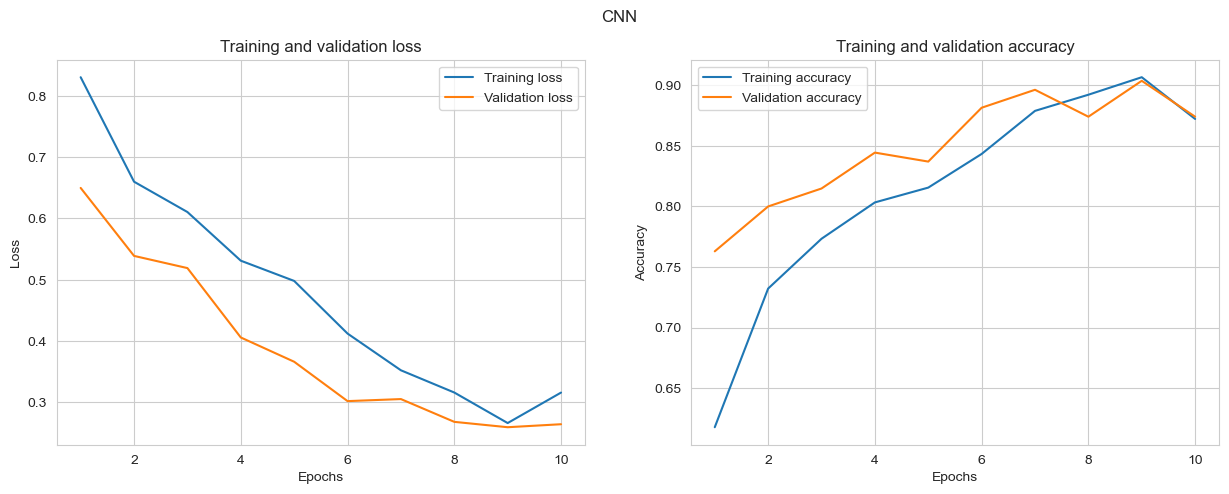

In [14]:
plot_training_history(cnn_history, "CNN")

In [15]:
cnn_test_preds = model_cnn.predict(test_gen, steps=test_steps, verbose=1)

9/9 [==============================] - 1s 46ms/step


In [16]:
cnn_test_preds = np.argmax(cnn_test_preds, axis=1)
test_labels = test_gen.classes

print(classification_report(test_labels, cnn_test_preds, target_names=classes_names))

              precision    recall  f1-score   support

      cloudy       1.00      0.75      0.86        24
        rain       0.84      0.94      0.89        17
       shine       0.95      1.00      0.98        20
     sunrise       0.91      1.00      0.95        29

    accuracy                           0.92        90
   macro avg       0.93      0.92      0.92        90
weighted avg       0.93      0.92      0.92        90



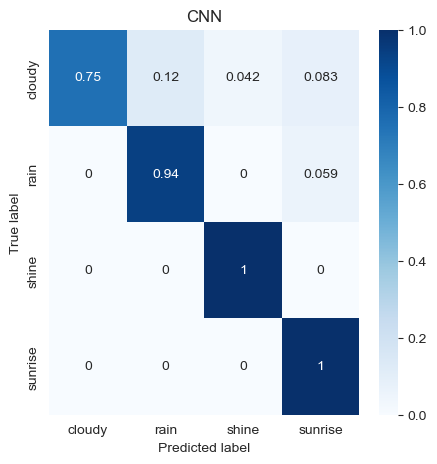

In [17]:
plot_confusion_matrix(test_labels, cnn_test_preds, "CNN", classes_names)

### Model with augmentated images

In [21]:
aug_model = Sequential()

aug_model.add(Conv2D(filters=filters_num, kernel_size=kernel_size, activation='relu', input_shape=img_shape))
aug_model.add(MaxPooling2D(pool_size=pool_size))
aug_model.add(Conv2D(filters=filters_num, kernel_size=3, activation='relu'))
aug_model.add(MaxPooling2D(pool_size=pool_size))
aug_model.add(Conv2D(filters=filters_num, kernel_size=3, activation='relu'))
aug_model.add(MaxPooling2D(pool_size=pool_size))
aug_model.add(Flatten())
aug_model.add(Dense(256, activation='relu'))
aug_model.add(Dropout(0.5))
aug_model.add(Dense(4, activation='softmax'))

aug_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

aug_model._name = "CNN_aug"
aug_model.summary()

Model: "CNN_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 219, 219, 32)      3488      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 32)       0   

In [22]:
aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                            zoom_range=0.2, horizontal_flip=True)

iterator = iter(train_df["filename"])

while iterator:
    next_image = next(iterator)
    image = Image.open(next_image)

    image = np.expand_dims(image, axis=0)
    try:
        aug_images = aug.flow(image, batch_size=1)
        next_aug_image = aug_images.next()
        next_aug_image = next_aug_image.astype(np.uint8)
        next_aug_image = Image.fromarray(next_aug_image[0])
        next_aug_image.save(os.path.join('augmented_images', f'aug_{os.path.basename(next_image)}'))
    except:
        print(next_image)

c:\Users\Manik\projects\deep-learning-portfolio\Weather-image-classification\dataset\cloudy66.jpg
c:\Users\Manik\projects\deep-learning-portfolio\Weather-image-classification\dataset\rain141.jpg
c:\Users\Manik\projects\deep-learning-portfolio\Weather-image-classification\dataset\shine131.jpg
c:\Users\Manik\projects\deep-learning-portfolio\Weather-image-classification\dataset\cloudy71.jpg


StopIteration: 

In [27]:
aug_train_df = pd.DataFrame(columns=["filename", "label"])

aug_train_df["filename"] = [os.path.join(os.getcwd(), "augmented_images", i) for i in os.listdir("augmented_images")]
aug_train_df["label"] = (aug_train_df["filename"].str.split("_")
               .str[-1].str.split(".")
               .str[0].str.replace("[^a-zA-Z]", "", regex=True)
)

aug_train_df = pd.concat([aug_train_df, train_df], ignore_index=True)

In [28]:
augmentated_train_gen = ImageDataGenerator(rescale=1./255)

augmentated_train_gen = augmentated_train_gen.flow_from_dataframe(aug_train_df, x_col='filename', y_col='label', target_size=img_size,
                                                                  class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 1796 validated image filenames belonging to 4 classes.


In [29]:
aug_history = aug_model.fit(augmentated_train_gen, validation_data=valid_gen, epochs=10, verbose=1)

Epoch 1/10
29/29 [==============================] - 24s 786ms/step - loss: 0.8634 - accuracy: 0.6197 - val_loss: 0.5554 - val_accuracy: 0.7481
Epoch 2/10
29/29 [==============================] - 19s 639ms/step - loss: 0.6328 - accuracy: 0.7617 - val_loss: 0.4396 - val_accuracy: 0.8296
Epoch 3/10
29/29 [==============================] - 28s 971ms/step - loss: 0.5055 - accuracy: 0.8157 - val_loss: 0.3362 - val_accuracy: 0.8370
Epoch 4/10
29/29 [==============================] - 24s 792ms/step - loss: 0.4498 - accuracy: 0.8296 - val_loss: 0.3654 - val_accuracy: 0.8667
Epoch 5/10
29/29 [==============================] - 18s 613ms/step - loss: 0.3937 - accuracy: 0.8641 - val_loss: 0.2767 - val_accuracy: 0.9037
Epoch 6/10
29/29 [==============================] - 20s 683ms/step - loss: 0.3711 - accuracy: 0.8703 - val_loss: 0.2553 - val_accuracy: 0.9111
Epoch 7/10
29/29 [==============================] - 18s 629ms/step - loss: 0.3045 - accuracy: 0.8953 - val_loss: 0.2601 - val_accuracy: 0.8741

In [ ]:
# save_model(aug_model, "cnn_aug")
# save_history(aug_history, "aug")

In [32]:
aug_model = load_model_from_file("cnn_aug")
aug_history = load_history_from_file("aug")

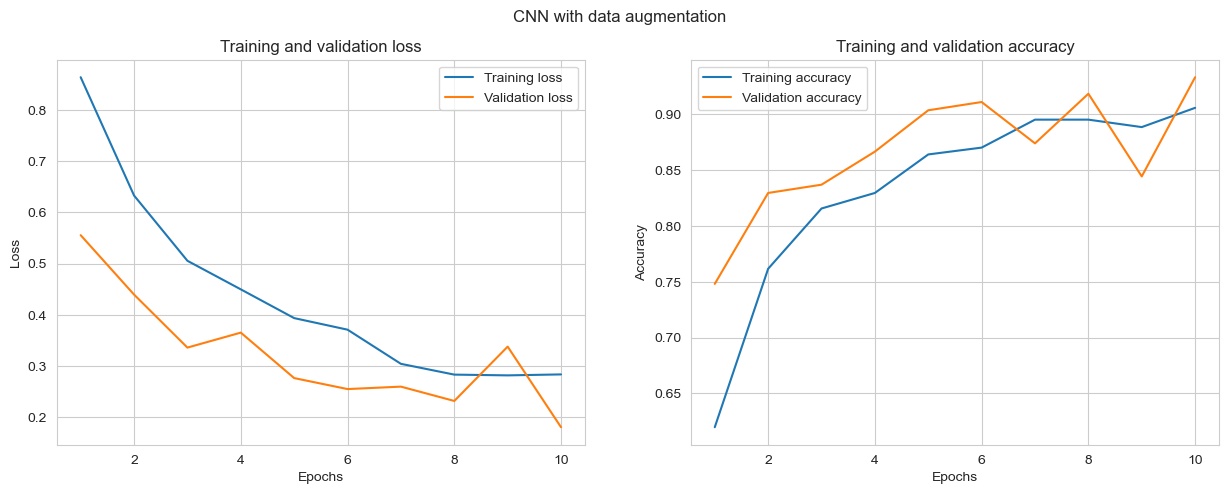

In [20]:
plot_training_history(aug_history, "CNN with data augmentation")

In [21]:
aug_preds = aug_model.predict(test_gen, steps=test_steps, verbose=1)
aug_preds = np.argmax(aug_preds, axis=1)

9/9 [==============================] - 1s 50ms/step


In [22]:
test_labels = test_gen.classes
print(classification_report(test_labels, aug_preds, target_names=classes_names))

              precision    recall  f1-score   support

      cloudy       0.95      0.88      0.91        24
        rain       0.94      1.00      0.97        17
       shine       0.95      0.95      0.95        20
     sunrise       0.97      1.00      0.98        29

    accuracy                           0.96        90
   macro avg       0.95      0.96      0.95        90
weighted avg       0.96      0.96      0.95        90



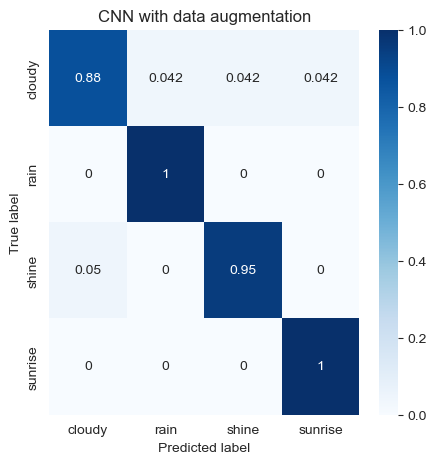

In [23]:
plot_confusion_matrix(test_labels, aug_preds, "CNN with data augmentation", classes_names)

### Using VGG16

In [62]:
class_count = len(list(train_gen.class_indices.keys()))

vgg_16 = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

for layer in vgg_16.layers:
    layer.trainable = False

x = vgg_16.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(class_count, activation='softmax')(x)

model = Model(inputs=vgg_16.input, outputs=predictions)

model.summary()

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [63]:
epochs = 10

history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs, verbose=1)

Epoch 1/10
15/15 [==============================] - 99s 7s/step - loss: 3.9574 - accuracy: 0.4300 - val_loss: 0.4432 - val_accuracy: 0.8815
Epoch 2/10
15/15 [==============================] - 123s 8s/step - loss: 0.6302 - accuracy: 0.7578 - val_loss: 0.4185 - val_accuracy: 0.8222
Epoch 3/10
15/15 [==============================] - 104s 7s/step - loss: 0.3563 - accuracy: 0.8733 - val_loss: 0.3137 - val_accuracy: 0.9185
Epoch 4/10
15/15 [==============================] - 120s 8s/step - loss: 0.2485 - accuracy: 0.9156 - val_loss: 0.2982 - val_accuracy: 0.9111
Epoch 5/10
15/15 [==============================] - 129s 9s/step - loss: 0.1817 - accuracy: 0.9489 - val_loss: 0.2286 - val_accuracy: 0.9481
Epoch 6/10
15/15 [==============================] - 138s 9s/step - loss: 0.1484 - accuracy: 0.9622 - val_loss: 0.2476 - val_accuracy: 0.9185
Epoch 7/10
15/15 [==============================] - 144s 10s/step - loss: 0.1233 - accuracy: 0.9811 - val_loss: 0.2090 - val_accuracy: 0.9481
Epoch 8/10
15

In [64]:
# model.save(os.path.join('models', 'vgg_16.h5'))
# save_history(history, "vgg_16")

In [27]:
vgg_16_model = load_model_from_file("vgg_16")
vgg_16_history = load_history_from_file("vgg16")

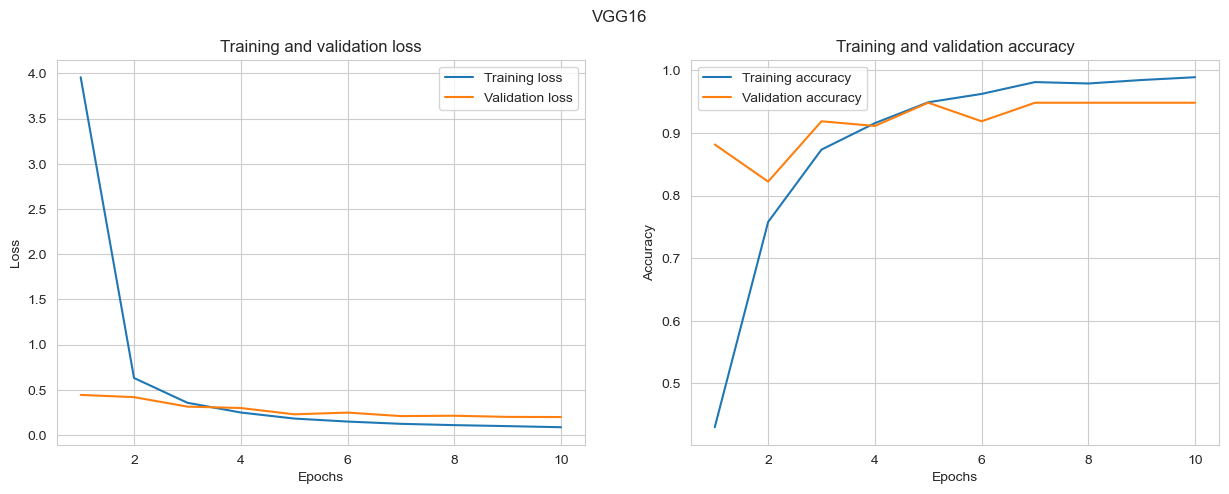

In [28]:
plot_training_history(vgg_16_history, "VGG16")

In [29]:
vgg_16_preds = vgg_16_model.predict(test_gen, verbose=1)
vgg_16_preds = np.argmax(vgg_16_preds, axis=1)

9/9 [==============================] - 9s 972ms/step


In [30]:
print(classification_report(test_gen.classes, vgg_16_preds, target_names=classes_names))

              precision    recall  f1-score   support

      cloudy       0.88      0.96      0.92        24
        rain       0.94      1.00      0.97        17
       shine       1.00      0.80      0.89        20
     sunrise       0.97      1.00      0.98        29

    accuracy                           0.94        90
   macro avg       0.95      0.94      0.94        90
weighted avg       0.95      0.94      0.94        90



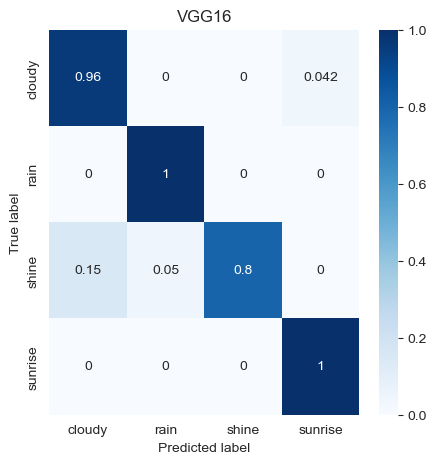

In [31]:
plot_confusion_matrix(test_gen.classes, vgg_16_preds, "VGG16", classes_names)